In [1]:
train <- read.csv(file = '../../Data/training_data.csv')
library(tree)
library(randomForest)
library(tidymodels)

data.train <- train[,-3]

foo <- function(dat) {
    out <- lapply(dat, function(x) length(unique(x)))
    want <- which(!out > 1)
    unlist(want)
}
               
                  
#load data
test <- read.csv(file = '../../Data/test_data.csv')
test <- na.omit(test)
test <- test[,-1]

ID <- foo(data.train)
       
data <- (data.train[,-ID])
ID <- ID - 1
test <- (test[,-ID])
                  

Warning message:
"package 'tree' was built under R version 3.6.3"randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.
Warning message:
"package 'tidymodels' was built under R version 3.6.3"Registered S3 method overwritten by 'cli':
  method     from
  print.tree tree
-- Attaching packages ------------------------------------------------------------------------------ tidymodels 0.1.2 --
v broom     0.7.2      v recipes   0.1.15
v dials     0.0.9      v rsample   0.0.8 
v dplyr     1.0.2      v tibble    3.0.4 
v ggplot2   3.3.2      v tidyr     1.1.2 
v infer     0.5.3      v tune      0.1.2 
v modeldata 0.1.0      v workflows 0.2.1 
v parsnip   0.1.4      v yardstick 0.0.7 
v purrr     0.3.4      
Warning message:
"package 'broom' was built under R version 3.6.3"Warning message:
"package 'dials' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning

In [89]:
dim(test)
dim(data)

[1]   68 3028

[1]  708 3029

## Simple tree


Regression tree:
tree(formula = VALENCE.PLEASANTNESS ~ ., data = data)
Variables actually used in tree construction:
 [1] "RDF015s"        "Chi_Dz.i."      "MATS8p"         "R4m"           
 [5] "L2s"            "Mor29s"         "RTs."           "X4sol"         
 [9] "Mor26m"         "P1p"            "Mor10u"         "P_VSA_m_2"     
[13] "RDF040m"        "SpMaxA_AEA.ed." "Mor17s"         "MATS2i"        
[17] "Dv"             "SIC1"           "ATSC1e"         "Mor18s"        
Number of terminal nodes:  21 
Residual mean deviance:  315 = 216400 / 687 
Distribution of residuals:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-57.0200 -11.2500   0.1897   0.0000  12.6800  54.8500 

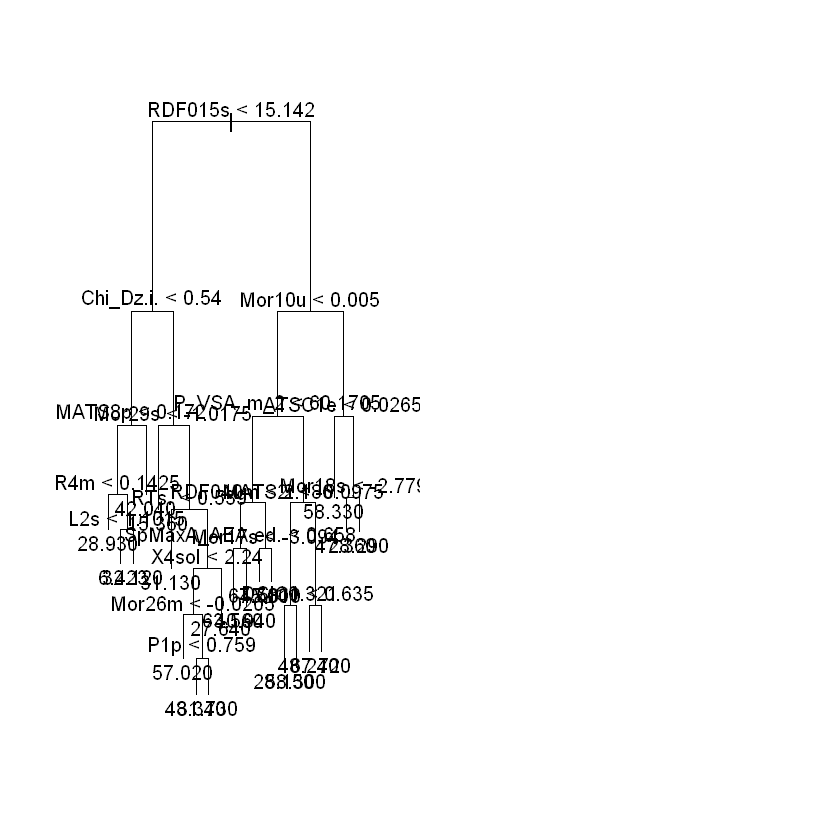

In [13]:
T <- tree(VALENCE.PLEASANTNESS ~ ., data)
summary(T) #affiche missclassification sur le training data
# visualize tree
par(mfrow = c(1, 2))
plot(T)
text(T)

# Random Forest

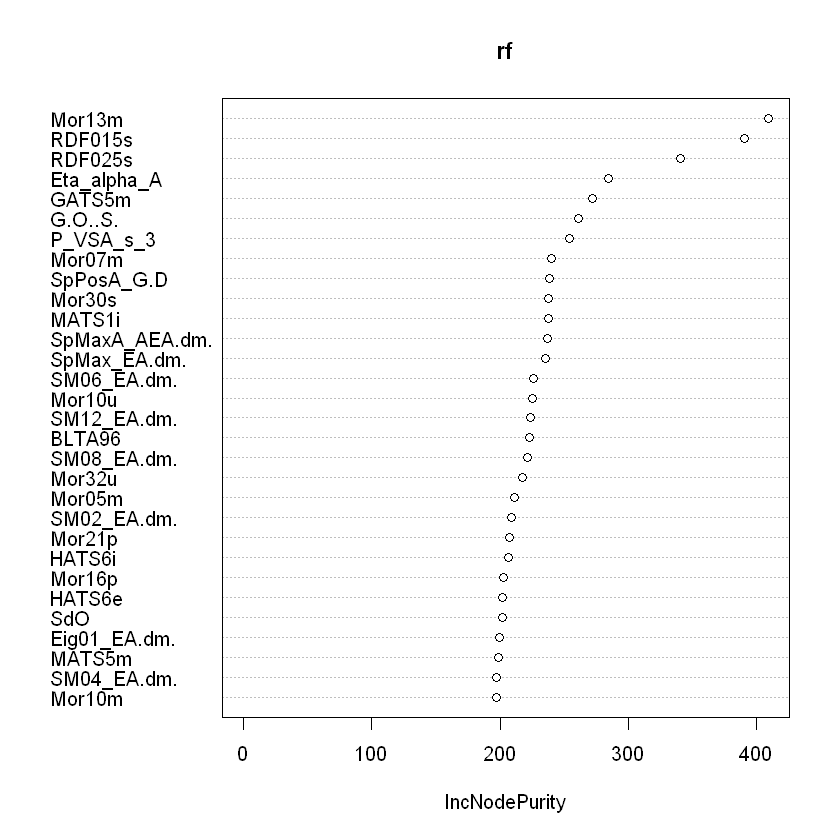

In [6]:
#mtry: nbr de variable a considéer
#ntree: number of tree grow on a bagging sample
rf <- randomForest(VALENCE.PLEASANTNESS ~ ., data.train, mtry = 50, ntree = 1000, maxnodes = 20)
varImpPlot(rf)

### Study RF with cross validation -> find best mtry, maxnodes.

In [9]:
fit_and_evaluate.mtry <- function(fold, mtry) {      
    sapply (seq(5,mtry,by = 50), function (i) {
        tree <- randomForest(VALENCE.PLEASANTNESS ~ ., analysis(fold), mtry = i, ntree = 100, maxnodes = 20) 
        valid.set <- assessment(fold)
        mean((valid.set$VALENCE.PLEASANTNESS-predict(tree,valid.set))^2)
    })
}



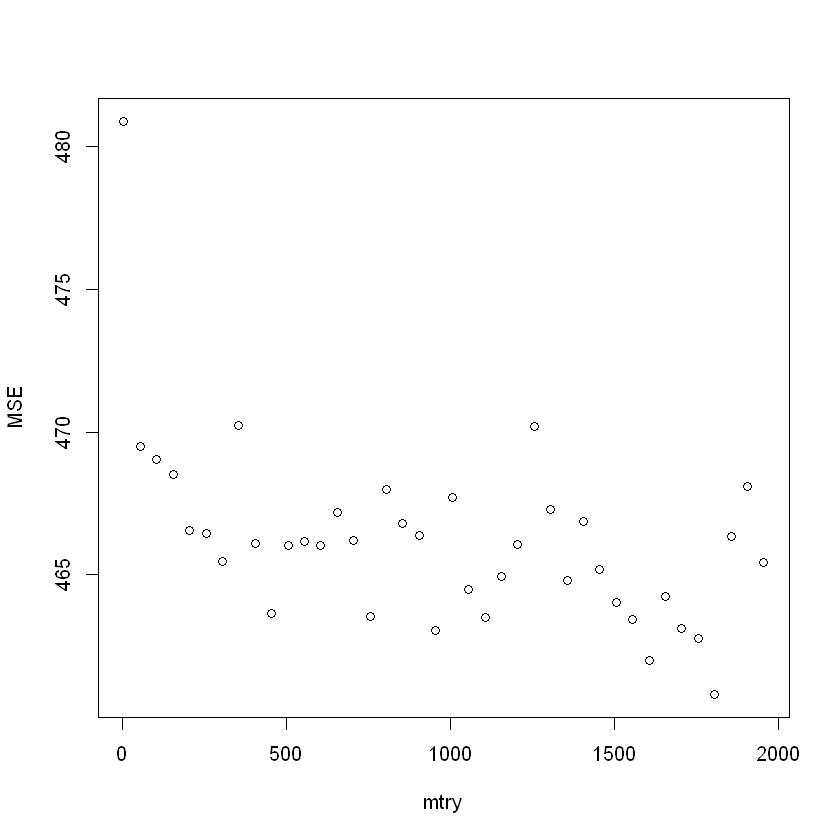

In [10]:
#NOT GOOD, too slow
validation_data <- vfold_cv(data.train, v = 8) #v = nbr of fold !
mtry <- 2000

v.errors <- sapply(validation_data$splits, fit_and_evaluate.mtry,mtry = mtry)
v.errors.mtry <- rowMeans(v.errors)
plot(seq(5,mtry,by = 50),v.errors.mtry,xlab = 'mtry', ylab = 'MSE')

In [11]:
seq(5,mtry,by = 50)[which.min(v.errors.mtry)]

[1] 1805

### Study RF with CV to find the best maxnodes

In [139]:
fit_and_evaluate.maxN <- function(fold, maxnodes) {      
    iter <- seq(1,maxnodes,by = 10)
    sapply (iter, function (i) {
        tree <- randomForest(VALENCE.PLEASANTNESS ~ ., analysis(fold), mtry = 115, ntree = 100, maxnodes = i) 
        valid.set <- assessment(fold)
        mean((valid.set$VALENCE.PLEASANTNESS-predict(tree,valid.set))^2)
    })
}


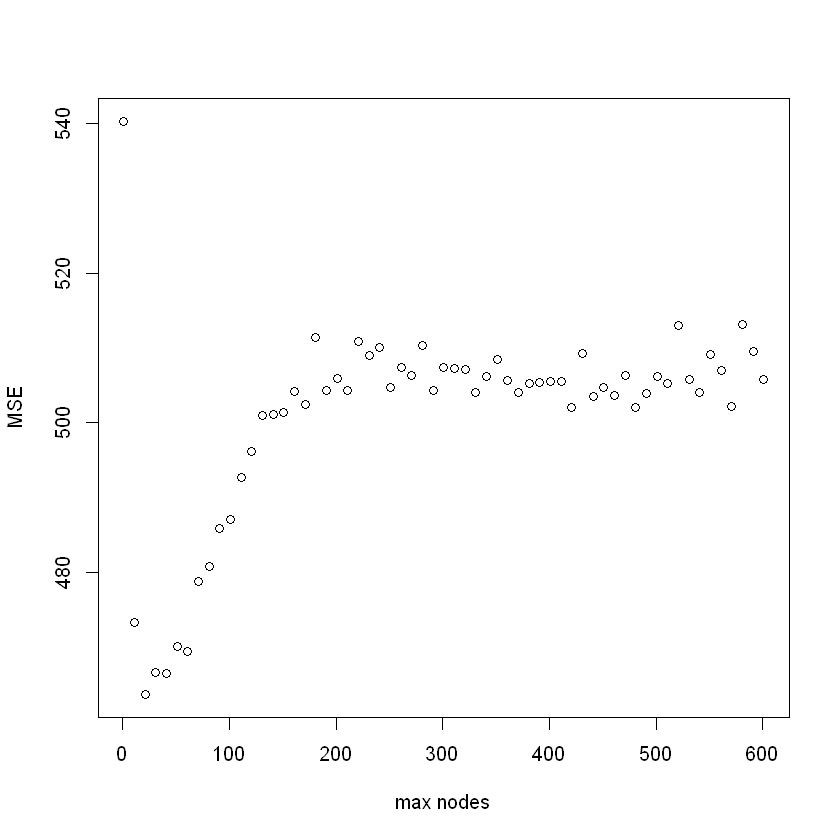

In [140]:
#NOT GOOD, too slow
validation_data <- vfold_cv(data, v = 10) #v = nbr of fold !  ####RELANCER AVEC dATA
maxnodes <- 601
v.errors <- sapply(validation_data$splits, fit_and_evaluate.maxN,maxnodes)
v.errors.maxnodes <- rowMeans(v.errors)
plot(seq(1,maxnodes,by = 10),v.errors.maxnodes,xlab='max nodes',ylab = 'MSE')

In [141]:
seq(1,maxnodes,by = 10)[which.min(v.errors.maxnodes)]


[1] 21

So it gives ~ 21 ! 

### simple way to roughly estimate the validation error (with the data pre processed)

note: this is more a way to compare our runs with different parameter, if we want to get a more precise estimate, we should do a proper CV.

In [6]:
set.seed(2)
MSE <- c()
data$Intensity <- as.numeric(data$Intensity) #If we do not do this, we have problem with the auto one hot coding of RF when using test set

for (i in 10){
    id <- sample(nrow(data),nrow(data)*3/4)
    train <- data[id,]
    valid <- data[-id,]
    RF <- randomForest(VALENCE.PLEASANTNESS ~ ., train, mtry = 1800, ntree = 555, maxnodes = 21)
    MSE <- append(MSE,mean((predict(RF,valid[,-2])-valid$VALENCE.PLEASANTNESS)^2))
    }
mean(MSE)

[1] 506.7572

### CV for ntree

In [ ]:
MSE <- c()
for (N in seq(5,2000,by = 50)){
    mse <- c()
    for (i in 1:8){
        id <- sample(nrow(data),nrow(data)*3/4)
        train <- data[id,]
        valid <- data[-id,]
        RF <- randomForest(VALENCE.PLEASANTNESS ~ ., train, mtry = 115, ntree = N, maxnodes = 21)
        mse <- append(mse,mean((predict(RF,valid[,-2])-valid$VALENCE.PLEASANTNESS)^2))
        }
    MSE <- append(MSE,mean(mse))
    }


[1] 555

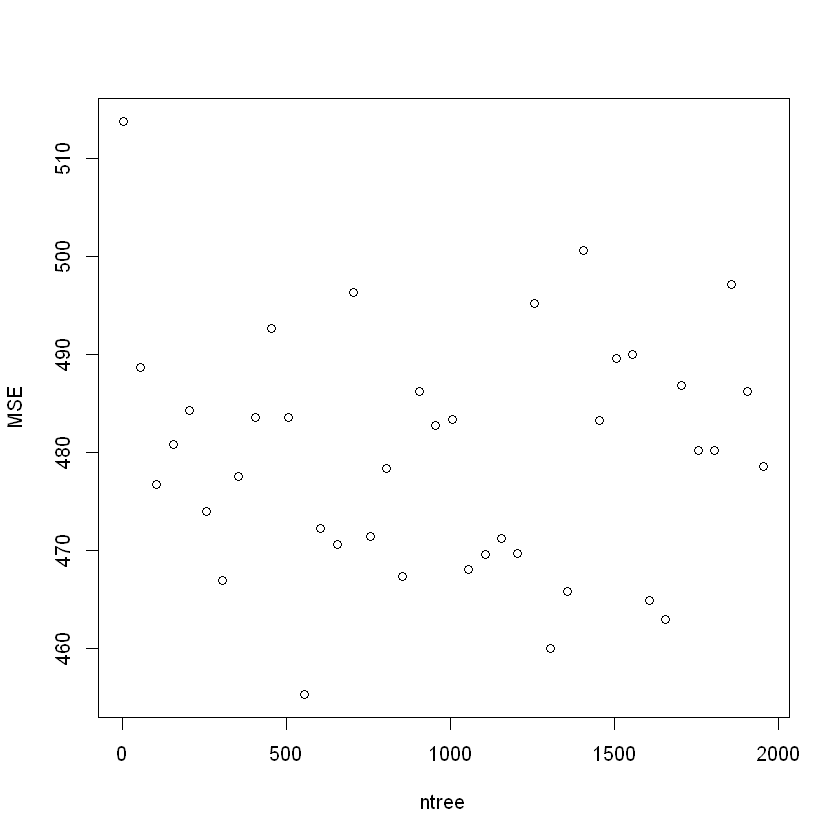

In [138]:
plot(seq(5,2000,by = 50),MSE,xlab = 'ntree', ylab = 'MSE')
seq(5,2000,by = 50)[which.min(MSE)]

a bit random 

### plot importance (sert a air)

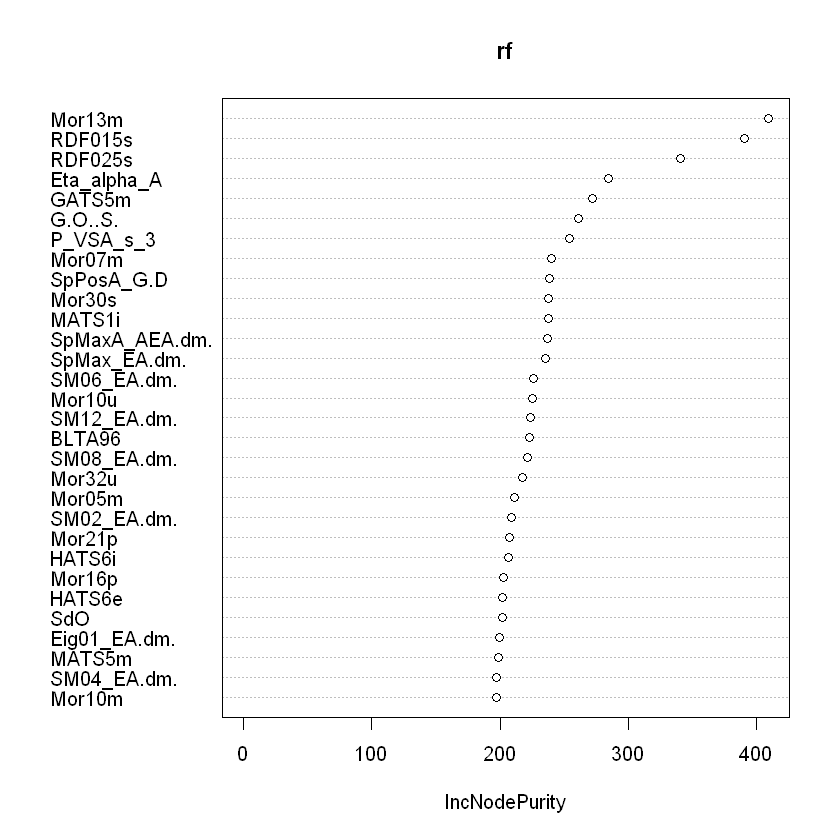

In [8]:
varImpPlot(rf)

### Run our optimized RF on test set

In [ ]:
#train full RF on full data data
test$Intensity <- as.numeric(test$Intensity) #If we do not do this, we have problem with the auto one hot coding of RF

RF.best <- randomForest(VALENCE.PLEASANTNESS ~ .,data, mtry = 1800, ntree = 555, maxnodes = 21)

In [148]:
y.pred <- predict(RF.best,test) #force RF to consider the same one hot coding
id <- 1:68
final.data <- data.frame(Id = id,VALENCE.PLEASANTNESS = y.pred)
write.csv(final.data,"../../Submission/RFgood.csv",row.names = FALSE)

In [133]:
# data.train$Intensity <- as.numeric(data.train$Intensity)
# test$Intensity <- as.numeric(test$Intensity) #If we do not do this, we have problem with the auto one hot coding of RF
# RF.best <- randomForest(VALENCE.PLEASANTNESS ~ .,data.train, mtry = 115, ntree = 200, maxnodes = 21)
# y.pred <- predict(RF.best,test) #force RF to consider the same one hot coding
# id <- 1:68
# final.data <- data.frame(Id = id,VALENCE.PLEASANTNESS = y.pred)
# write.csv(final.data,"../../Submission/RF.csv",row.names = FALSE)